In [1]:
import imgtda
from imgtda import locally_striped as ls
from imgtda.locally_striped import defect_analysis as da

import collections

import numpy as np
import pandas as pd
from scipy import misc
from matplotlib import pyplot as plt

%matplotlib inline

## Set Up Project

In [2]:
myproject = imgtda.Project

myproject['directory'] = '/Users/birdbrain/Documents/Research/Projects/Schatz/Data/g21chaotic/r4000_2015_09_16_fast'
myproject['bmp_format'] = 'g21flow/bmps/%06d.bmp'
myproject['pd_sub_format'] = 'g21flow/pd_sub/%06d.csv'
myproject['pd_sup_format'] = 'g21flow/pd_sup/%06d.csv'
myproject['additional_data'] = {'lyap_format':'g21per/bmps_abs_val/%05d.bmp',
                                'delta':40}


## Utility Functions

In [3]:
def load_image_data(project, idx):
    
    im = ls.image.load_image_from_file(project['directory'] + "/" + (project['bmp_format'] % idx))
    im.load_sublevel_pd(project['directory'] + "/" + (project['pd_sub_format'] % idx))
    im.load_superlevel_pd(project['directory'] + "/" + (project['pd_sup_format'] % idx))
    
    return im

def load_lyap_data(project, idx):
    
    lyap = misc.imread(project['directory'] + "/" + (project['additional_data']['lyap_format'] % idx))
    
    return lyap

def cropping_region():
    # Plot the results
    # Crop the temperature field to a circle first.
    c = np.zeros((421,421))
    centerx = 210
    centery = 210
    radius=200
    for i in range(c.shape[0]):
        for j in range(c.shape[1]):
            if ((i-centerx)**2 + (j-centery)**2 < radius**2):
                c[i,j] = 1
    c = c.astype(np.int)

    return c

## The Code

In [4]:
def fill_smoothing_weights(idx_range, smoothing_window):
    
    weights = {}

    for defect_type in da.DEFECT_TYPES:
        weights[defect_type] = []
    weights['unclassified'] = []
    weights['defect-free'] = []
    
    for idx in idx_range:
        im = get_image_defects(idx, sigma, radius)

        weights = append_smoothing_weight(im, weights, smoothing_window)

    return weights

def append_smoothing_weight(im, weights, smoothing_window):
    
    for defect_type in da.DEFECT_TYPES:
        weights[defect_type].append(im.defect_regions[defect_type]/float(smoothing_window))
    weights['unclassified'].append(im.unclassified_defect_region/float(smoothing_window))
    weights['defect-free'].append(im.defect_free_region/float(smoothing_window))

    return weights

def pop_smoothing_weight(weights):
    
    for defect_type in da.DEFECT_TYPES:
        weights[defect_type].pop(0)
    weights['unclassified'].pop(0)
    weights['defect-free'].pop(0)

    return weights

def get_sum_of_weights(weights):
    
    sum_of_weights = {}
    
    for defect_type in da.DEFECT_TYPES:
        sum_of_weights[defect_type] = np.asarray([sum(i) for i in zip(*weights[defect_type])])
    sum_of_weights['unclassified'] = np.asarray([sum(i) for i in zip(*weights['unclassified'])])
    sum_of_weights['defect-free'] = np.asarray([sum(i) for i in zip(*weights['defect-free'])])
    
    return sum_of_weights

def get_image_defects(idx, sigma, radius):

    im = load_image_data(myproject, idx)
    im.generate_orientation_field(sigma,1)
    im.get_persistent_h1_generators(myproject['additional_data']['delta'])
    im.classify_defects(sigma,radius,'serial')

    return im

def plot_image_defects(im):
    
    c = cropping_region()

    print_bmp = im.bmp.copy()
    print_bmp[c==0] = 0
    fig = da.plot_defect_classifications(print_bmp, 
                                   im.all_defects, 
                                   im.unclassified_defect_region, 
                                   im.orientation_fields[sigma].topological_defects, 
                                   im.defect_free_region);
    return fig

def get_image_defect_stats(im):
    
    image_defect_stats = {}
    
    for defect_type in da.DEFECT_TYPES:
        image_defect_stats[defect_type] = 0
    
    for defect in im.all_defects:
        image_defect_stats[defect['defect_type']] = image_defect_stats[defect['defect_type']] + 1
        
    return image_defect_stats


def get_lyapunov_stats(idx, im, lyap, lyap_cutoff, sum_of_weights):
    
    lyap_thresholded = np.multiply((lyap >= lyap_cutoff).astype(np.float), lyap.astype(np.float))
    lyap_thresholded = lyap_thresholded/255. # Normalize
    
    lyap_integrals = {}
    
    for defect_type in da.DEFECT_TYPES:
        lyap_integrals[defect_type] = sum(sum(np.multiply(lyap_thresholded, sum_of_weights[defect_type])))
    
    lyap_integrals['unclassified'] = sum(sum(np.multiply(lyap_thresholded, sum_of_weights['unclassified'])))
    lyap_integrals['defect-free'] = sum(sum(np.multiply(lyap_thresholded, sum_of_weights['defect-free'])))
    
    return lyap_integrals



## Process Images

In [5]:
from pprint import pprint as pp

sigma = 3
radius = 10
lyap_cutoffs = [0.2, 0.35, 0.5, 0.65, 0.8]

plot_the_things = 0

process_range = range(100, 110)
smoothing_windows = [1, 5, 10, 15]

weights = {}
for window in smoothing_windows:
    print window
    weights[window] = fill_smoothing_weights(range(process_range[0] - window + 1, process_range[0]), window)

all_lyap_stats = {}
for lyap_cutoff in lyap_cutoffs:
    all_lyap_stats[lyap_cutoff] = {}
    for window in smoothing_windows:
        all_lyap_stats[lyap_cutoff][window] = {}
        for defect_type in da.DEFECT_TYPES:
            all_lyap_stats[lyap_cutoff][window][defect_type] = []
        all_lyap_stats[lyap_cutoff][window]['unclassified'] = []
        all_lyap_stats[lyap_cutoff][window]['defect-free'] = []

for idx in process_range:
    
    print idx
    
    im = get_image_defects(idx, sigma, radius)
    image_defect_stats = get_image_defect_stats(im)
    
    if plot_the_things:
        plt.imshow(im.bmp)
        plt.colorbar()
        plt.show()
        
        plot_image_defects(im)
        plt.show()
        
        plt.set_cmap('jet');
        plt.rcParams['figure.figsize'] = (5.0, 5.0);
    
    lyap = load_lyap_data(myproject, idx)
    c = cropping_region()
    lyap[c==0] = 0
    
    lyap_thresholded = {}
    for lyap_cutoff in lyap_cutoffs:
        lyap_thresholded[lyap_cutoff] = (lyap >= lyap_cutoff*255.).astype(np.float)

    # Get the integral statistics
    sum_of_weights = {}
    for window in smoothing_windows:
        
        if plot_the_things:
            print "Window %d:" % window
        
        # Compute new weight arrays
        weights[window] = append_smoothing_weight(im, weights[window], window)
        
        sum_of_weights[window] = get_sum_of_weights(weights[window])

        for lyap_cutoff in lyap_cutoffs:
            lyap_stats = get_lyapunov_stats(idx, im, lyap, lyap_cutoff*255., sum_of_weights[window])

            for defect_type in da.DEFECT_TYPES:
                all_lyap_stats[lyap_cutoff][window][defect_type].append(lyap_stats[defect_type])
                if plot_the_things:
                    plt.imshow(sum_of_weights[window][defect_type])
                    plt.colorbar()
                    plt.show()
            all_lyap_stats[lyap_cutoff][window]['unclassified'].append(lyap_stats['unclassified'])
            all_lyap_stats[lyap_cutoff][window]['defect-free'].append(lyap_stats['defect-free'])

            if plot_the_things:
                plt.imshow(sum_of_weights[window]['unclassified'])
                plt.colorbar()
                plt.show()
                plt.imshow(sum_of_weights[window]['defect-free'])
                plt.colorbar()
                plt.show()


            if plot_the_things:
                plt.imshow(np.multiply(lyap/255., lyap_thresholded[lyap_cutoff]))
                plt.colorbar()
                plt.show()

                plt.imshow(np.multiply(sum_of_weights[window]['defect-free'], np.multiply(lyap/255., lyap_thresholded[lyap_cutoff])))
                plt.colorbar()
                plt.show()
                print "Sum of these values: %0.4f" % sum(sum(np.multiply(sum_of_weights[window]['defect-free'], np.multiply(lyap/255., lyap_thresholded[lyap_cutoff]))))


        # Pop the first weight arrays off the list to make room for the new one
        weights[window] = pop_smoothing_weight(weights[window])

    if plot_the_things:
        print ""
        print "PROCESSING INDEX %d:" % (idx)
        print "Defect counts: "
        pp(image_defect_stats)
        print "Lyapunov integrals: "
        pp(all_lyap_stats)



1
5
10
15
100
101
102
103
104
105
106
107
108
109


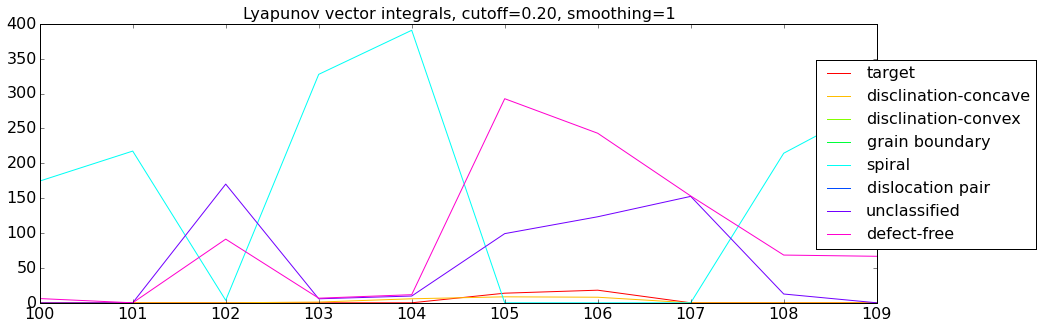

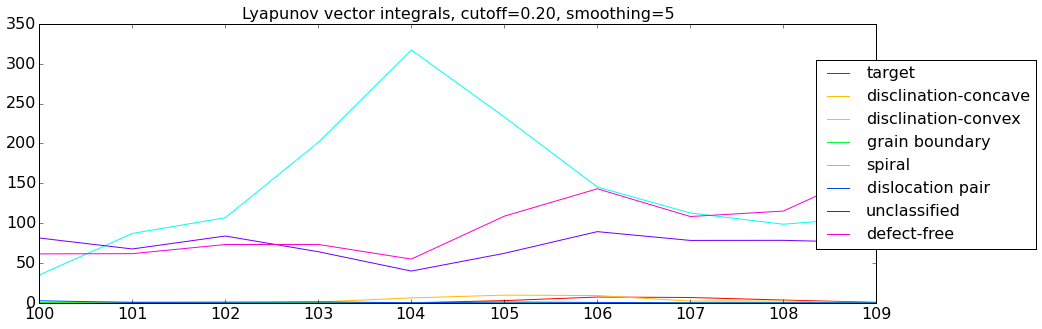

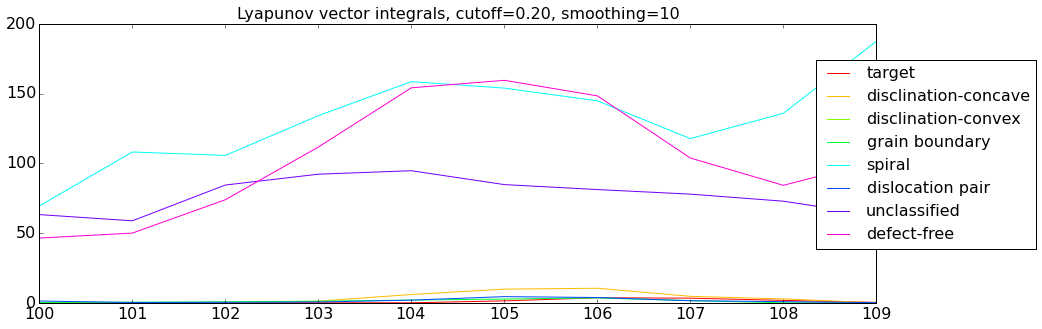

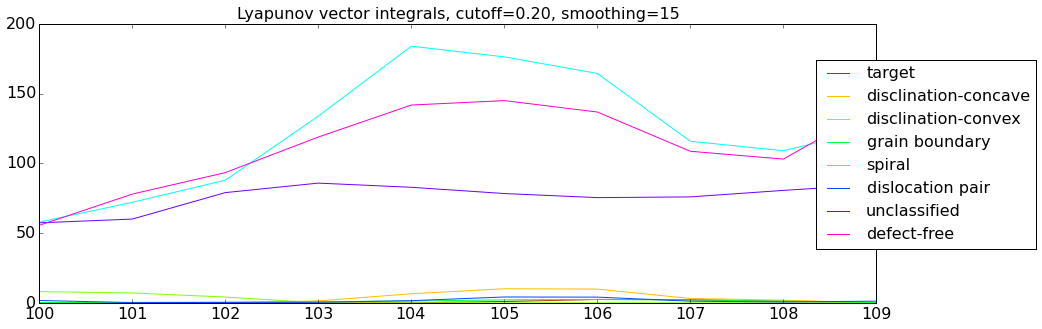

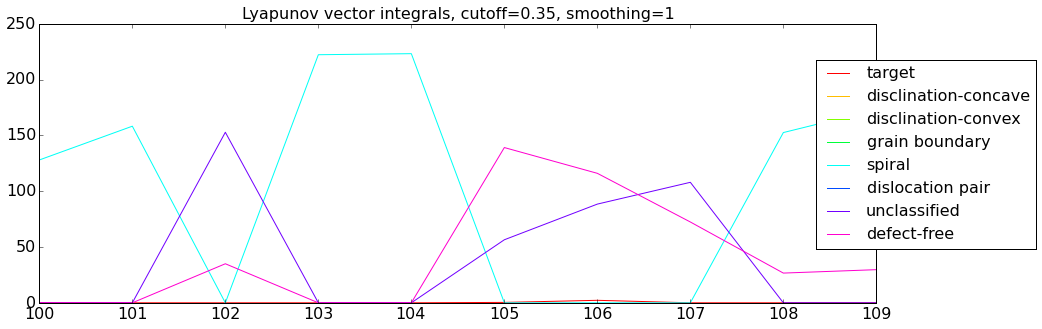

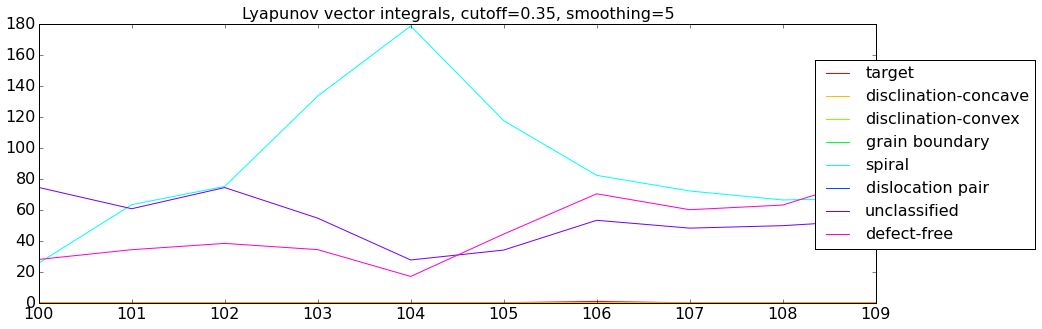

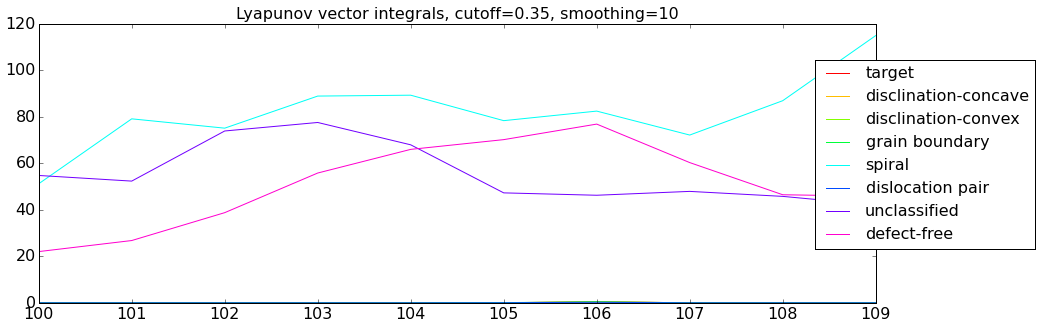

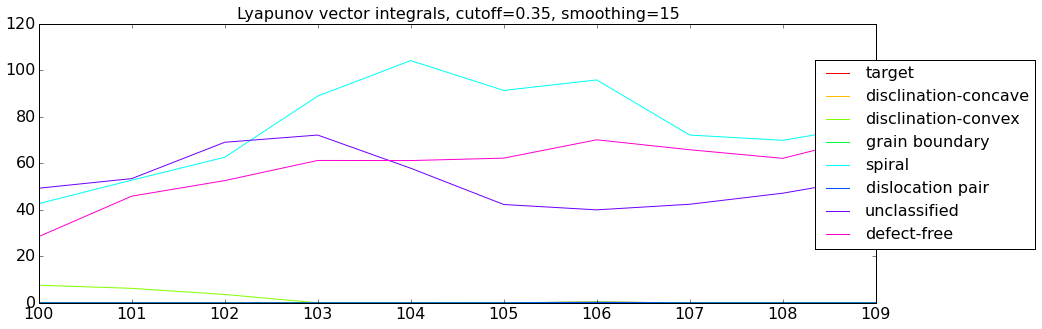

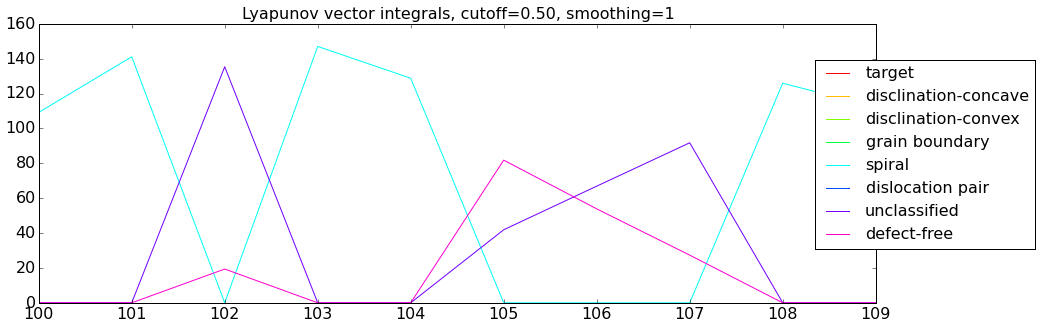

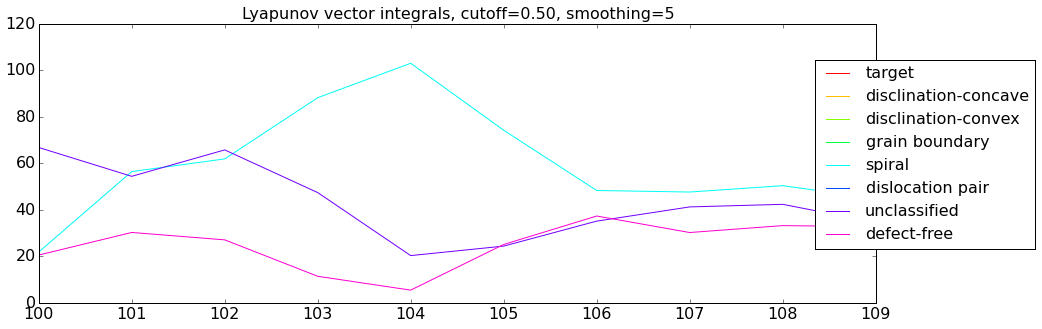

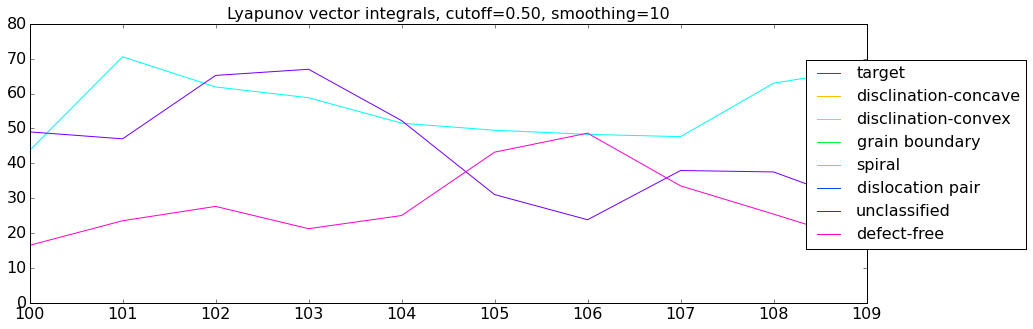

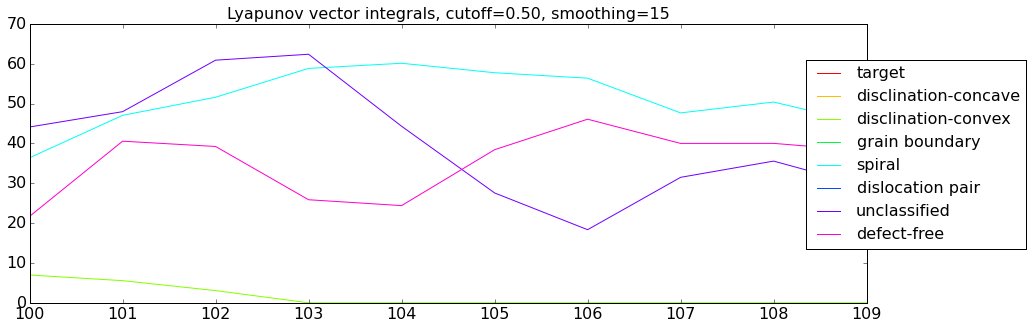

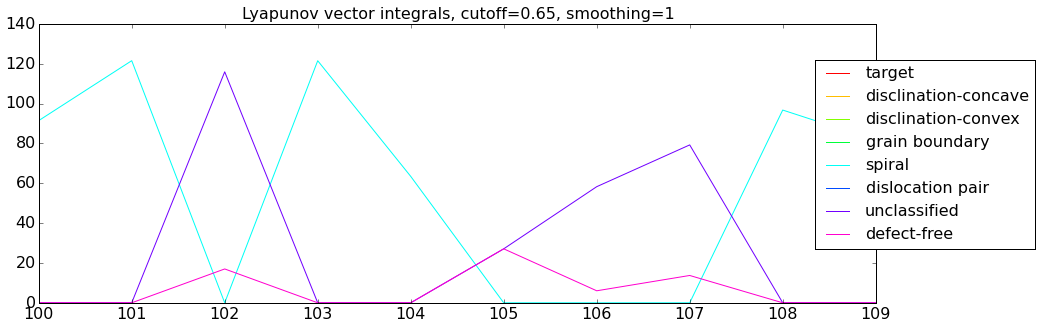

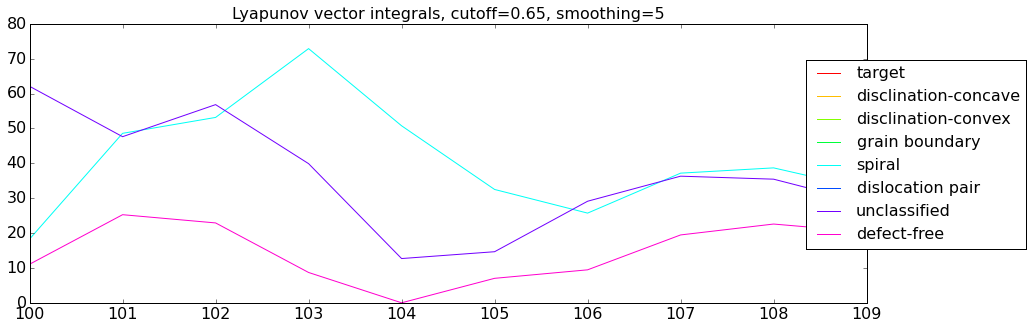

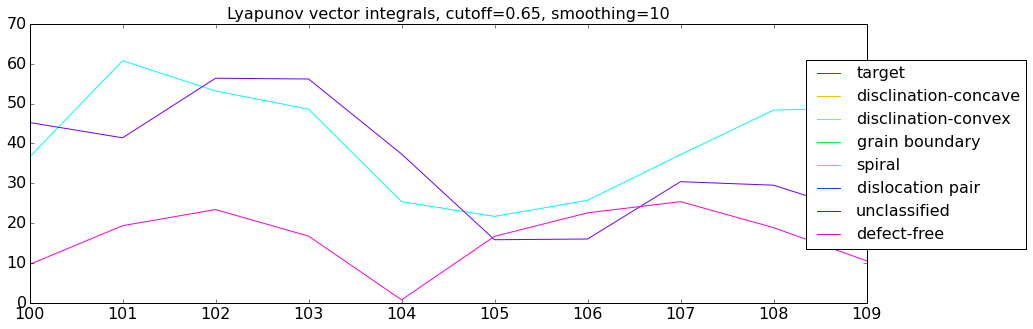

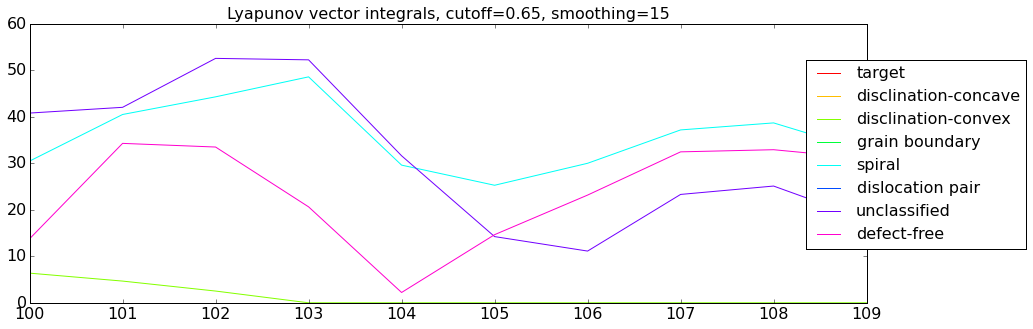

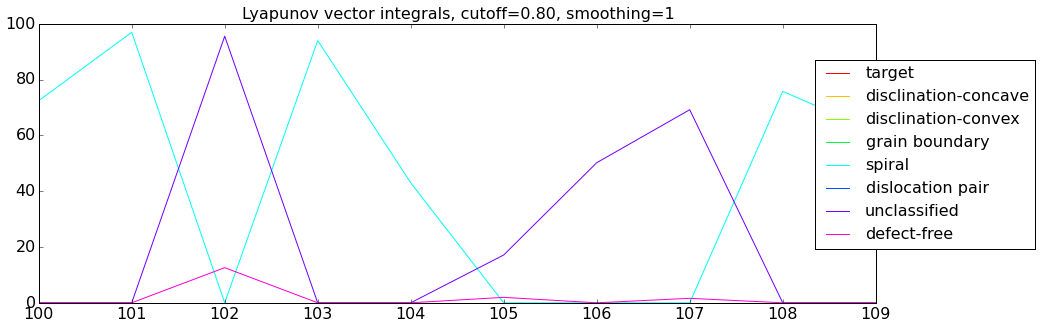

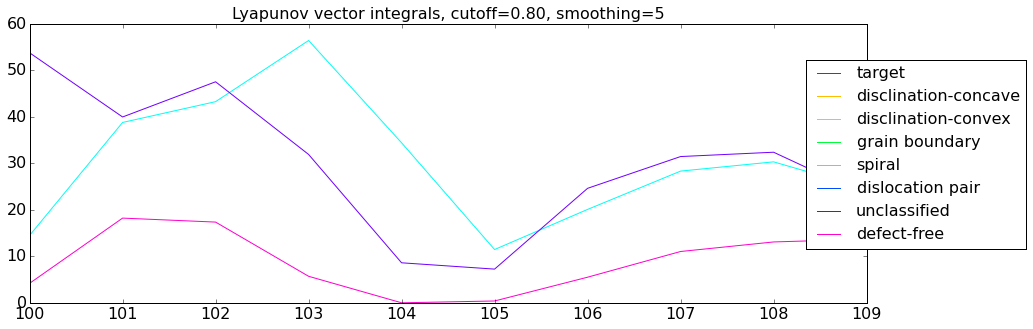

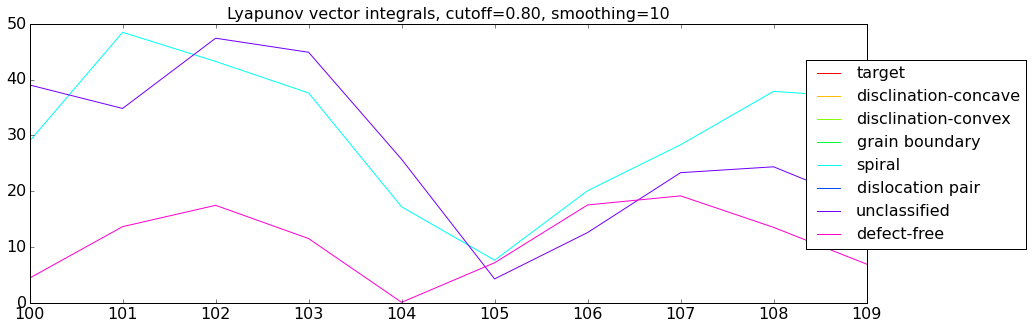

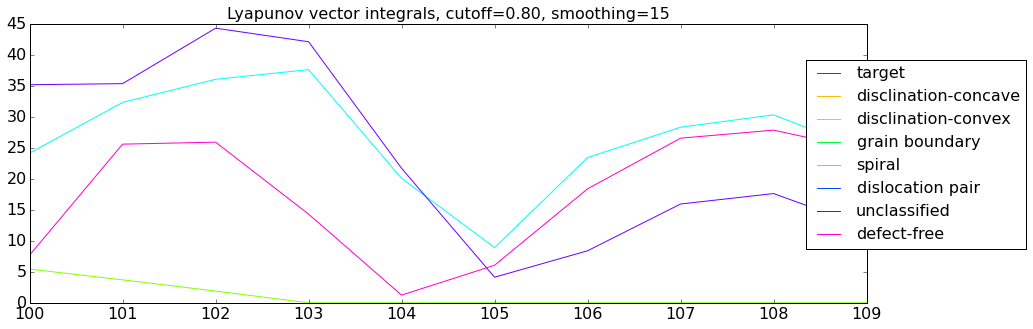

In [6]:
# Generate time series plots of integrals

plt.rcParams['figure.figsize'] = (15.0, 5.0);

NUM_COLORS = 8

cm = plt.get_cmap('hsv')

for lyap_cutoff in lyap_cutoffs:
    for window in smoothing_windows:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

        for defect_type in da.DEFECT_TYPES:
            ax.plot(process_range, all_lyap_stats[lyap_cutoff][window][defect_type], label=defect_type)
        ax.plot(process_range, all_lyap_stats[lyap_cutoff][window]['unclassified'], label='unclassified')
        ax.plot(process_range, all_lyap_stats[lyap_cutoff][window]['defect-free'], label='defect-free')
        plt.setp(ax.get_xticklabels(), fontsize=16)
        plt.setp(ax.get_yticklabels(), fontsize=16)
        ax.legend(fontsize=16, bbox_to_anchor=(1.2, 0.9))
        plt.title('Lyapunov vector integrals, cutoff=%0.2f, smoothing=%d' % (lyap_cutoff, window), fontsize=16)
        plt.show()
        


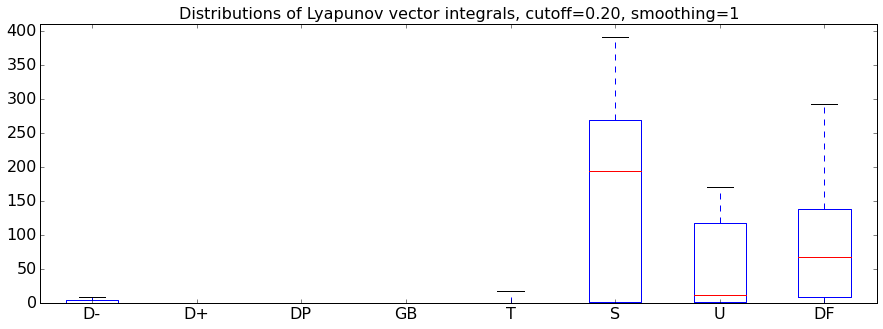

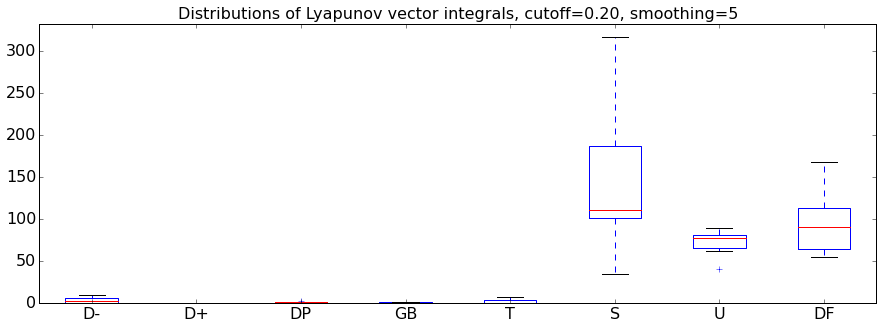

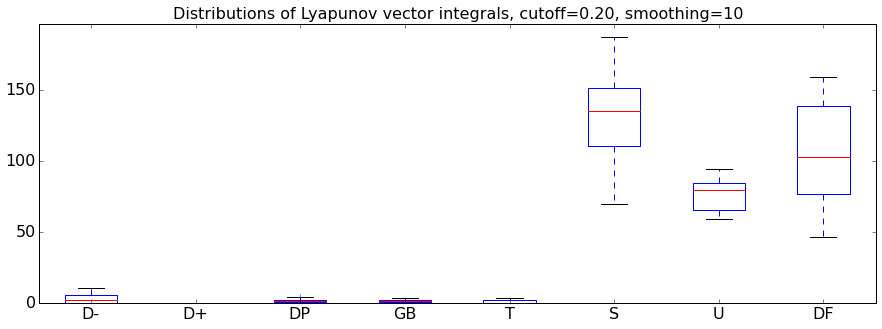

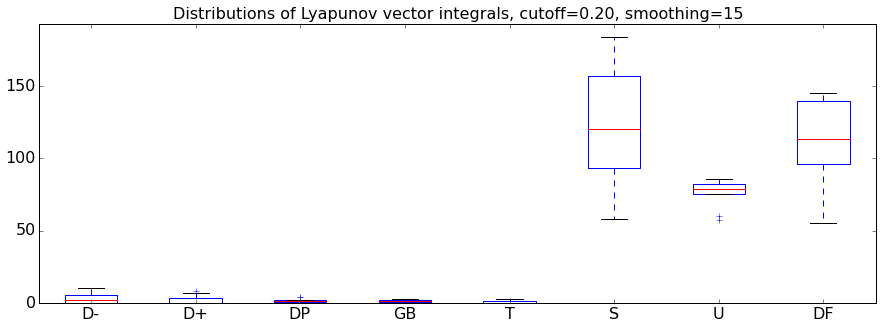

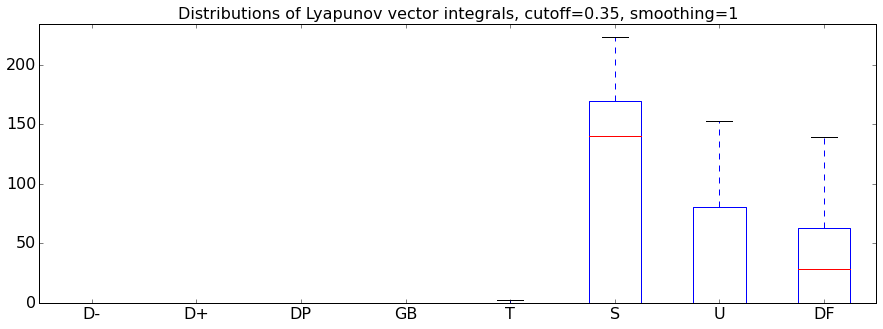

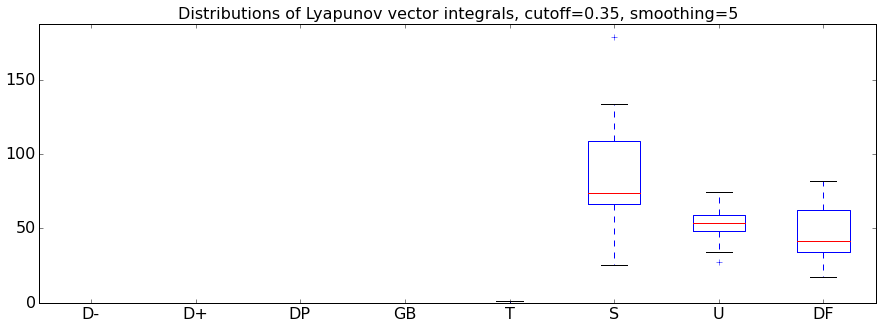

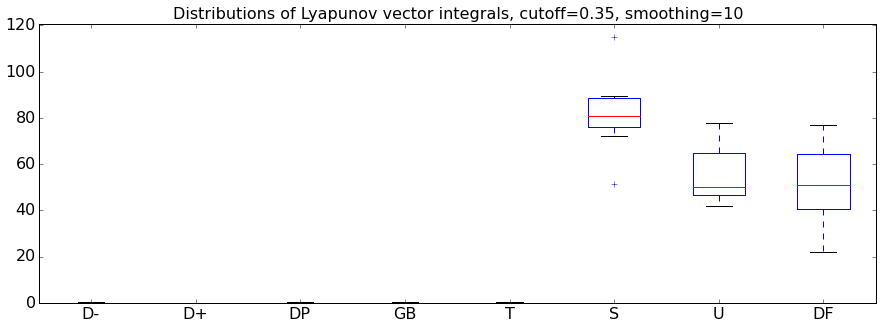

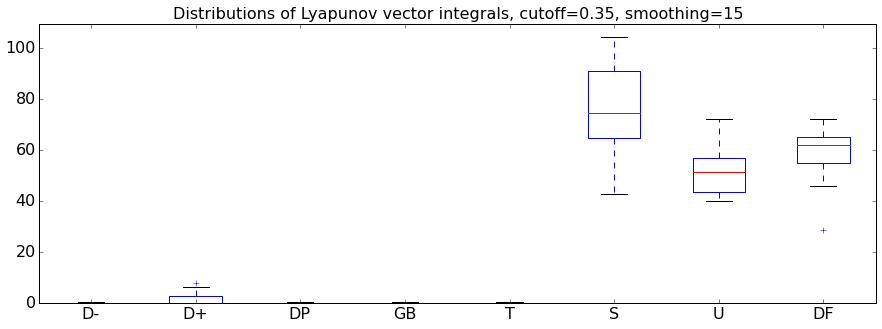

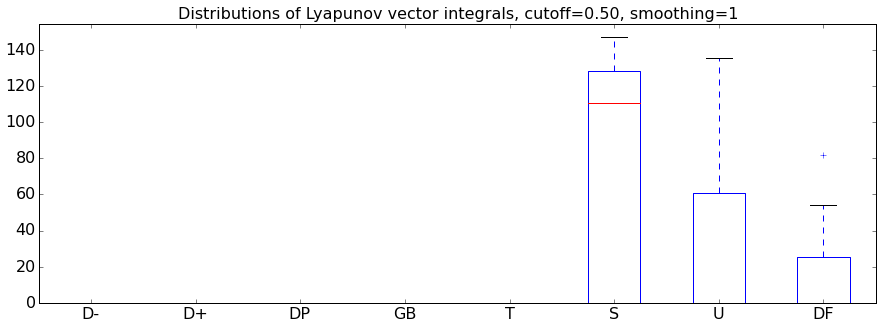

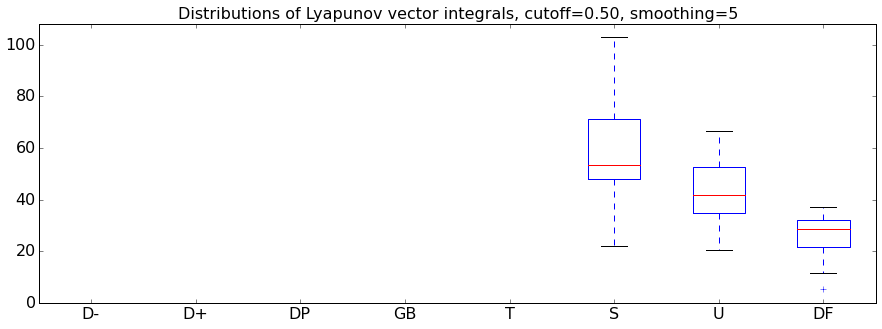

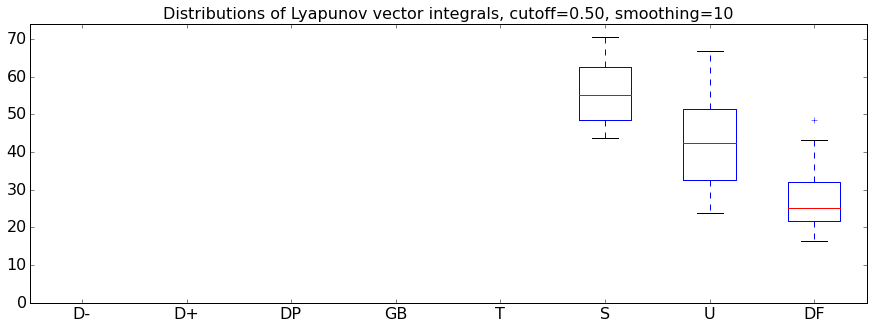

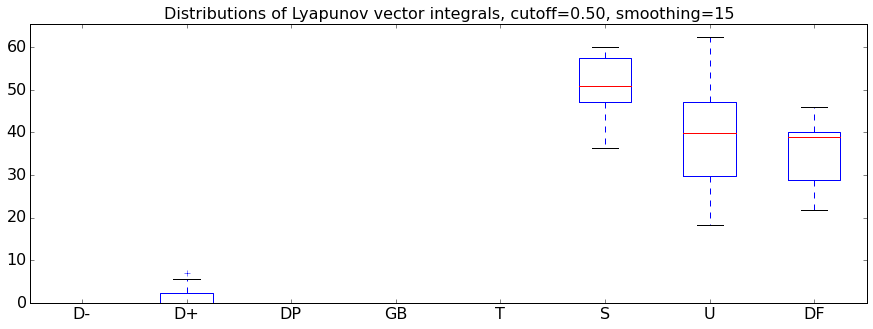

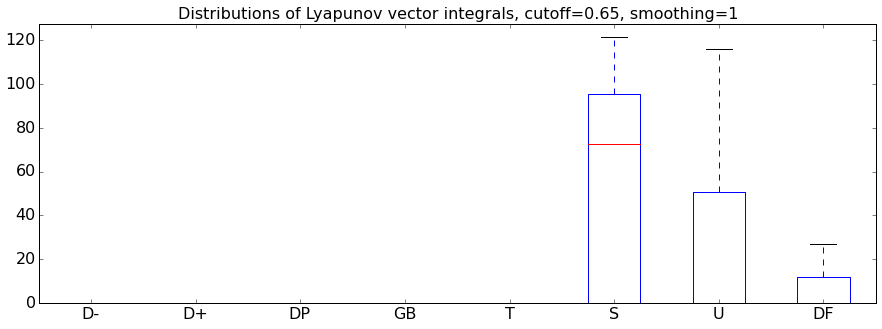

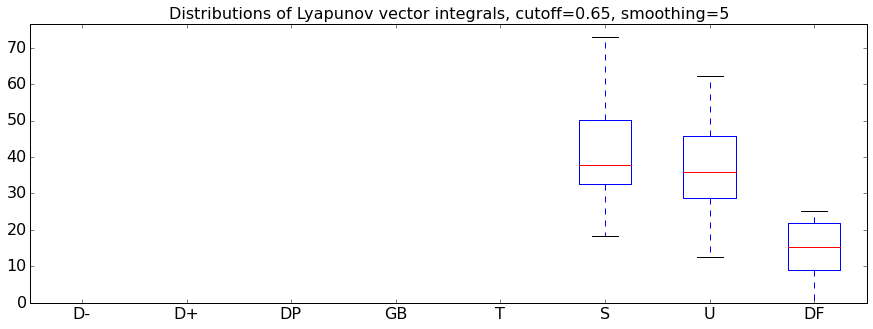

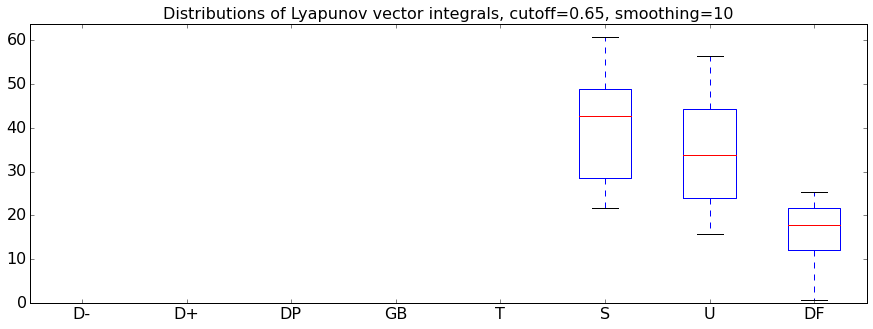

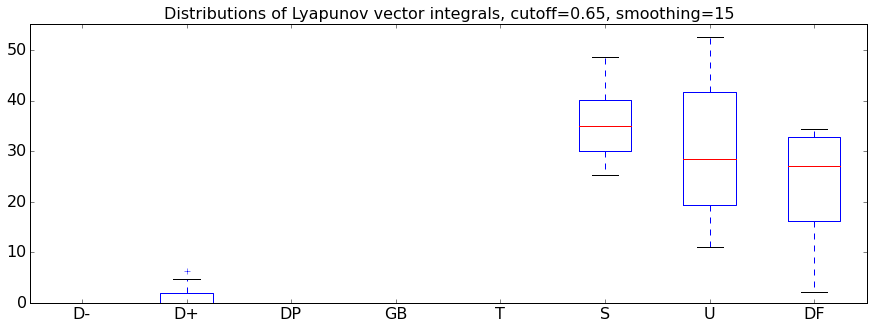

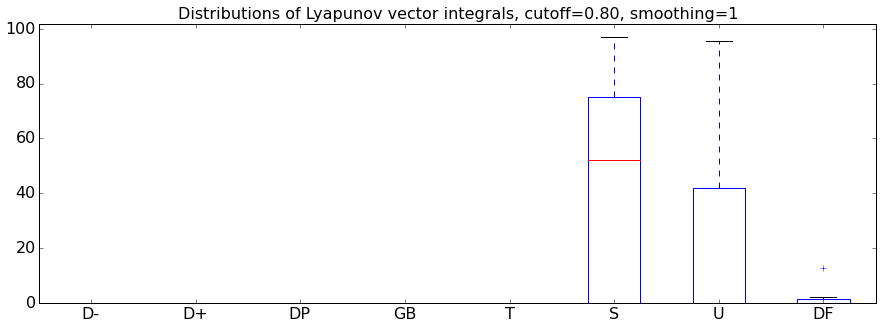

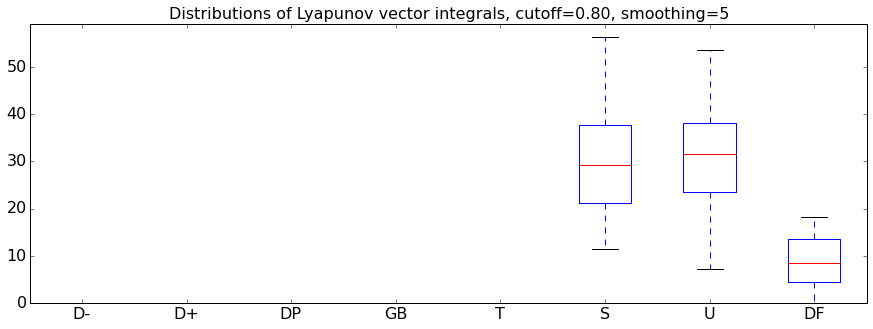

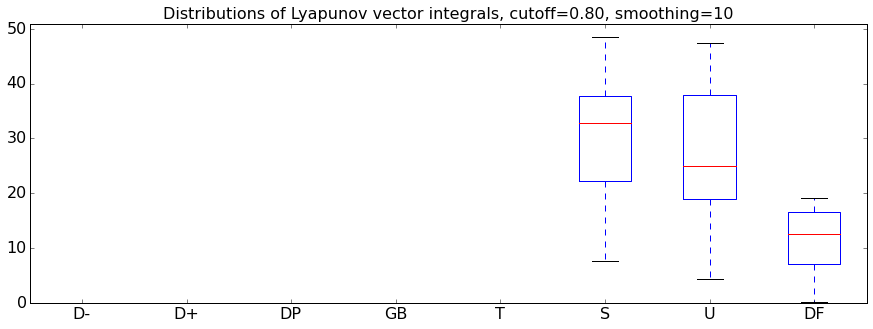

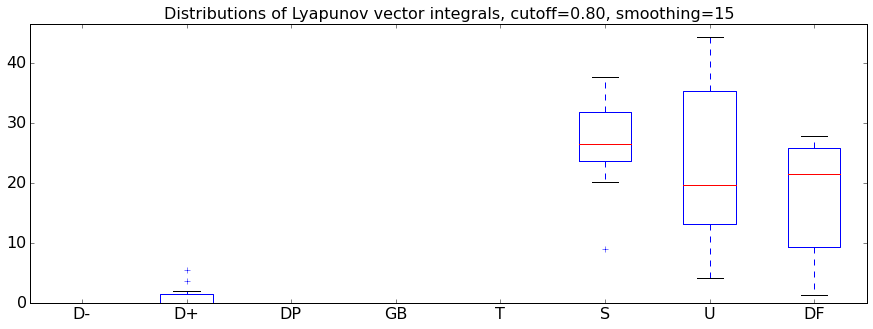

In [7]:
# Generate box plots of integrals

plt.rcParams['figure.figsize'] = (15.0, 5.0);

label_list = ['disclination-concave',
  'disclination-convex',
  'dislocation pair',
  'grain boundary',
  'target',
  'spiral',
  'unclassified',
  'defect-free']

label_abbrev = ['D-', 'D+', 'DP', 'GB', 'T', 'S', 'U', 'DF']

for lyap_cutoff in lyap_cutoffs:
    
    for window in smoothing_windows:
        
        plot_data = np.zeros((len(process_range), len(label_list)))
        
        for i in range(len(label_list)):
            
            plot_data[:,i] = all_lyap_stats[lyap_cutoff][window][label_list[i]]

        plt.title('Distributions of Lyapunov vector integrals, cutoff=%0.2f, smoothing=%d' % (lyap_cutoff, window), fontsize=16)
        plt.boxplot(plot_data, labels=label_abbrev)
        ax = plt.gca()
        plt.setp(ax.get_xticklabels(), fontsize=16)
        plt.setp(ax.get_yticklabels(), fontsize=16)
        plt.ylim([0,np.max(np.max(plot_data))*1.05])
        plt.show()
    
    

<IPython.core.display.Javascript object>


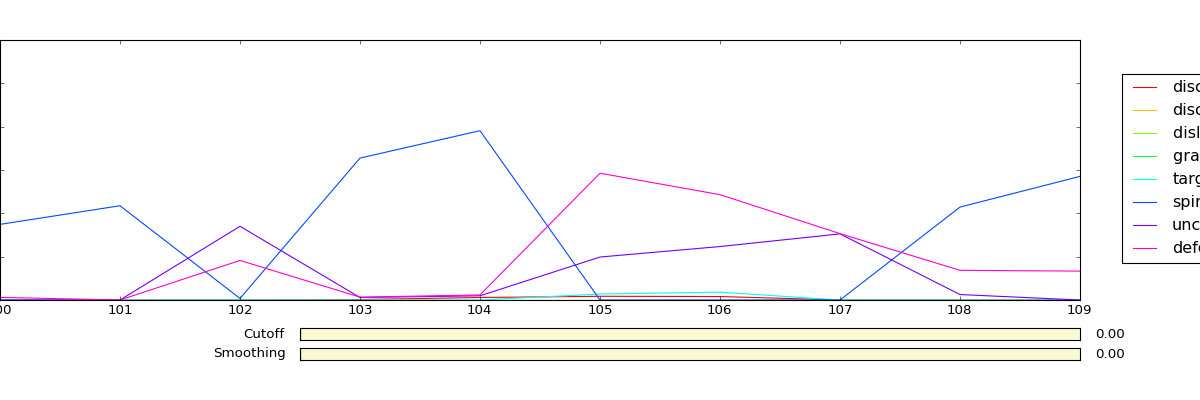

In [62]:
from matplotlib.widgets import Slider, Button, RadioButtons
%matplotlib notebook

# Generate box plots of integrals

plt.rcParams['figure.figsize'] = (15.0, 5.0);

label_list = ['disclination-concave',
  'disclination-convex',
  'dislocation pair',
  'grain boundary',
  'target',
  'spiral',
  'unclassified',
  'defect-free']

label_abbrev = ['D-', 'D+', 'DP', 'GB', 'T', 'S', 'U', 'DF']

plot_data = np.zeros((len(process_range), len(label_list), len(lyap_cutoffs), len(smoothing_windows)))

for lyap_cutoff in range(len(lyap_cutoffs)):
    for window in range(len(smoothing_windows)):
        for i in range(len(label_list)):
            plot_data[:, i, lyap_cutoff, window] = np.asarray(all_lyap_stats[lyap_cutoffs[lyap_cutoff]][smoothing_windows[window]][label_list[i]])


axis_color = 'lightgoldenrodyellow'
fig = plt.figure()


NUM_COLORS = 8

cm = plt.get_cmap('hsv')

# Draw the plot
ax = fig.add_subplot(111)
fig.subplots_adjust(left=0.0, bottom=0.25)
cutoff_0 = 0
smoothing_0 = 0
lines = {}
ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
for i in range(len(label_list)):
    lines[i] = ax.plot(process_range, plot_data[:,i,cutoff_0, smoothing_0])
ax.set_xlim([process_range[0], process_range[-1]])
ax.set_ylim([0, 600])
ax.legend(labels=label_list, bbox_to_anchor=(1.25, 0.9))

# Add two sliders for tweaking the parameters
cutoff_slider_ax  = fig.add_axes([0.25, 0.15, 0.65, 0.03], axisbg=axis_color)
cutoff_slider = Slider(cutoff_slider_ax, 'Cutoff', 0, len(lyap_cutoffs), valinit=cutoff_0)
smoothing_slider_ax = fig.add_axes([0.25, 0.1, 0.65, 0.03], axisbg=axis_color)
smoothing_slider = Slider(smoothing_slider_ax, 'Smoothing', 0, len(smoothing_windows), valinit=smoothing_0)
def sliders_on_changed(val):
    for i in range(len(label_list)):
        line[i].set_ydata(signal(int(amp_slider.val), int(freq_slider.val)))
    fig.canvas.draw_idle()
cutoff_slider.on_changed(sliders_on_changed)
smoothing_slider.on_changed(sliders_on_changed)

# # Add a button for resetting the parameters
# reset_button_ax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
# reset_button = Button(reset_button_ax, 'Reset', color=axis_color, hovercolor='0.975')
# def reset_button_on_clicked(mouse_event):
#     freq_slider.reset()
#     amp_slider.reset()
# reset_button.on_clicked(reset_button_on_clicked)

# # Add a set of radio buttons for changing color
# color_radios_ax = fig.add_axes([0.025, 0.5, 0.15, 0.15], axisbg=axis_color)
# color_radios = RadioButtons(color_radios_ax, ('red', 'blue', 'green'), active=0)
# def color_radios_on_clicked(label):
#     line.set_color(label)
#     fig.canvas.draw_idle()
# color_radios.on_clicked(color_radios_on_clicked)

plt.show()

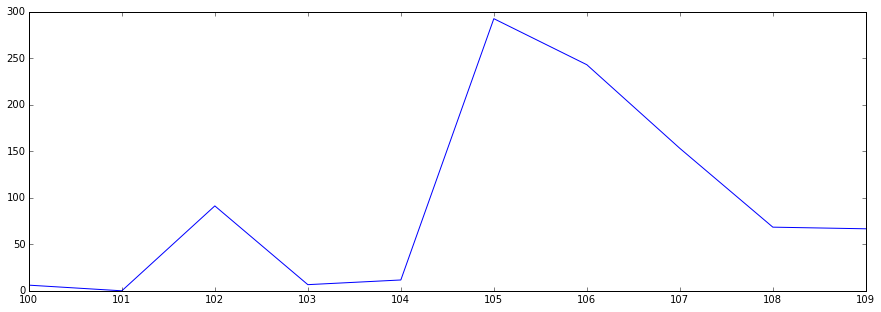

In [44]:
plt.plot(process_range, plot_data[:,i,cutoff_0, smoothing_0])

In [35]:
np.asarray(all_lyap_stats[lyap_cutoffs[1]][smoothing_windows[1]][label_list[7]])

array([ 27.97098039,  34.26196078,  38.32078431,  34.31215686,
        17.00941176,  44.34980392,  70.32862745,  60.05333333,
        63.06039216,  81.83294118])

In [36]:
plot_data[:, 7, 1, 1]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])